https://towardsdatascience.com/statistical-comparison-among-multiple-groups-with-anova-d4ac27f6e59e
https://www.kaggle.com/code/eisgandar/analysis-of-variance-anova-clearly-explained
https://www.kaggle.com/code/brekhnaa/analysis-of-variance-anova

In [1]:
# https://pypi.org/project/PuLP/
# https://coin-or.github.io/pulp/guides/index.html

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sqlite3 import connect
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)

In [6]:
pd.options.display.float_format = "{:.2f}".format

In [7]:
# Get the absolute path of the file within the INPUTS directory
file_path = os.path.join(os.getcwd(), 'INPUTS', 'case_study_data.csv')

# Print the file path
print(file_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\INPUTS\case_study_data.csv


In [8]:
# Get the absolute path of the config within the CONFIGS directory
config_path = os.path.join(os.getcwd(), 'CONFIGS', 'config.json')

# Print the fileconfig_pathpath
print(config_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\CONFIGS\config.json


In [9]:
with open(config_path, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [10]:
INDEX_COL = CONFIG["INPUTS"]["INDEX_COLUMNS"]
SEP = CONFIG["INPUTS"]["SEPARATOR"]
DECIMAL = CONFIG["INPUTS"]["DECIMAL"]
ENCODING = CONFIG["INPUTS"]["ENCODING"]
DATE_COLUMNS = CONFIG["INPUTS"]["DATE_COLUMNS"]
FLOAT_PRECISION = CONFIG["INPUTS"]["FLOAT_PRECISION"]
DTYPE = CONFIG["INPUTS"]["DTYPE"]
COLUMNS_WITH_NAN_VALUES = CONFIG["INPUTS"]["COLUMNS_WITH_NAN_VALUES"]
X_ORDER = CONFIG["X_ORDER"]
HUE_ORDER = CONFIG["HUE_ORDER"]

In [153]:
df = pd.read_csv(
    file_path,
#     index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    engine="c",
    low_memory=False,
#     parse_dates=DATE_COLUMNS,
    dtype=DTYPE
)

In [154]:
print(df.index.duplicated())

[False False False ... False False False]


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      9993 non-null   object 
 1   Order Date    9993 non-null   object 
 2   Ship Mode     9993 non-null   object 
 3   Region        9993 non-null   object 
 4   Product ID    9993 non-null   object 
 5   Category      9993 non-null   object 
 6   Sub-Category  9993 non-null   object 
 7   Product Name  9993 non-null   object 
 8   Sales         9993 non-null   float64
 9   Quantity      9993 non-null   int64  
 10  Discount      9993 non-null   float64
 11  Profit        8000 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 937.0+ KB


# PREPROCESSING

In [156]:
# df.index = pd.to_datetime(df["Order Date"])

In [157]:
# Use regex to separate the string parts of the Order ID column into separate fields
df[['Order ID prefix', 'Order ID year', 'Order ID number']] = df['Order ID'].str.extract(r'(\w+)-(\d+)-(\d+)')

# Use regex to separate the string parts of the Order Date column into separate fields
df[['Order Year', 'Order Month', 'Order Day']] = pd.to_datetime(df['Order Date']).dt.strftime('%Y-%m-%d').str.extract(r'(\d{4})-(\d{2})-(\d{2})')

In [158]:
# Normalize Profit column as new column
df['Normalized Profit'] = (df['Profit'] - df['Profit'].mean()) / df['Profit'].std()

In [159]:
# Normalize Sales column as new column
df['Normalized Sales'] = (df['Sales'] - df['Sales'].mean()) / df['Sales'].std()

In [160]:
# Standardize Profit column as new column
mean_profit = df['Profit'].mean()
std_profit = df['Profit'].std()
df['Standardized Profit'] = (df['Profit'] - mean_profit) / std_profit

In [161]:
# Standardize Sales column as new column
mean_sales = df['Sales'].mean()
std_sales = df['Sales'].std()
df['Standardized Sales'] = (df['Sales'] - mean_sales) / std_sales

In [162]:
df['Winsorized Sales'] = stats.mstats.winsorize(df['Sales'], limits=[0.05, 0.05])

In [163]:
df['Winsorized Profit'] = stats.mstats.winsorize(df['Profit'], limits=[0.10, 0.10])

In [164]:
# Use RobustScaler to scale Sales using IQR method as new column
scaler = RobustScaler()
df['Scaled Sales'] = scaler.fit_transform(df[['Sales']])
df['Scaled Profit'] = scaler.fit_transform(df[['Profit']])

In [165]:
# Create a FunctionTransformer object with a logarithmic transformation function
# log_transformer = FunctionTransformer(np.log1p)
log_transformer = FunctionTransformer(np.log10)

# Apply the logarithmic transformation to the "Sales" column
df['Log Sales'] = log_transformer.transform(df[['Sales']])
df['Log Profit'] = log_transformer.transform(df[['Profit']])

In [166]:
df["Category-SubCategory"] = df["Category"].str.cat(df["Sub-Category"], sep="-")

In [167]:
df_sample = df.sample(n=3000)
df_sample

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,...,Normalized Sales,Standardized Profit,Standardized Sales,Winsorized Sales,Winsorized Profit,Scaled Sales,Scaled Profit,Log Sales,Log Profit,Category-SubCategory
9180,PL-2017-133102,2017-08-17,Standard Class,Central,FUR-FU-10003247,Furniture,Furnishings,36X48 HARDFLOOR CHAIRMAT,16.78,2,...,-0.34,-0.22,-0.34,16.78,-8.43,-0.20,-1.10,1.22,NaN,Furniture-Furnishings
5380,PL-2017-148404,2017-10-07,Standard Class,South,TEC-PH-10004447,Technology,Phones,Toshiba IPT2010-SD IP Telephone,222.38,2,...,-0.01,-0.05,-0.01,222.38,16.68,0.87,0.28,2.35,1.22,Technology-Phones
6194,PL-2015-143105,2015-12-10,Same Day,East,OFF-PA-10002713,Office Supplies,Paper,"Adams Phone Message Book, 200 Message Capacity, 8 1/16” x 11”",41.28,6,...,-0.30,-0.04,-0.30,41.28,18.99,-0.07,0.36,1.62,1.28,Office Supplies-Paper
3626,PL-2016-106530,2016-05-08,Same Day,East,OFF-ST-10000649,Office Supplies,Storage,Hanging Personal Folder File,25.12,2,...,-0.33,-0.12,-0.33,25.12,1.57,-0.15,-0.26,1.40,0.20,Office Supplies-Storage
9267,PL-2015-144519,2015-11-13,Standard Class,West,TEC-PH-10004908,Technology,Phones,Panasonic KX TS3282W Corded phone,339.96,5,...,0.18,0.06,0.18,339.96,42.49,1.48,1.20,2.53,1.63,Technology-Phones
9164,PL-2017-125381,2017-04-25,Second Class,West,TEC-AC-10000158,Technology,Accessories,Sony 64GB Class 10 Micro SDHC R40 Memory Card,107.97,3,...,-0.20,-0.02,-0.20,107.97,22.67,0.28,0.49,2.03,1.36,Technology-Accessories
6447,PL-2016-147137,2016-07-04,First Class,West,OFF-ST-10002486,Office Supplies,Storage,Eldon Shelf Savers Cubes and Bins,27.92,4,...,-0.32,-0.12,-0.32,27.92,0.56,-0.14,-0.29,1.45,-0.25,Office Supplies-Storage
5989,PL-2015-105627,2015-03-08,Standard Class,Central,TEC-PH-10003012,Technology,Phones,Nortel Meridian M3904 Professional Digital phone,769.95,5,...,0.87,0.86,0.87,769.95,223.29,3.71,7.62,2.89,2.35,Technology-Phones
2645,PL-2017-140844,2017-06-19,Standard Class,East,OFF-PA-10003892,Office Supplies,Paper,Xerox 1943,97.82,2,...,-0.21,0.08,-0.21,97.82,45.98,0.22,1.32,1.99,1.66,Office Supplies-Paper
4936,PL-2017-126242,2017-11-19,Standard Class,West,OFF-ST-10000675,Office Supplies,Storage,"File Shuttle II and Handi-File, Black",305.01,9,...,0.12,0.21,0.12,305.01,76.25,1.30,2.40,2.48,1.88,Office Supplies-Storage


# SQL

In [26]:
conn = connect(':memory:')
df.to_sql('data', conn)

9993

# Aggregation

In [62]:
data = pd.read_sql(
"""
    SELECT
         "Order Year"
        ,"Order Month"
        ,Category
        ,"Sub-Category" AS SubCategory
        ,Region
        ,SUM("Quantity") AS Quantity
        ,SUM("Sales") AS Sales
        ,SUM("Profit") AS Profit
    FROM data
    GROUP BY
         "Order Year"
        ,"Order Month"
        ,Category
        ,"Sub-Category"
        ,Region
""",
conn
)

In [63]:
data

,Order Year,Order Month,Category,SubCategory,Region,Quantity,Sales,Profit
0,2014,01,Furniture,Bookcases,Central,2,141.96,NaN
1,2014,01,Furniture,Bookcases,East,4,61.96,-53.29
2,2014,01,Furniture,Bookcases,West,10,806.13,-313.25
3,2014,01,Furniture,Chairs,South,18,4187.70,1058.03
4,2014,01,Furniture,Furnishings,Central,9,364.40,-18.83
5,2014,01,Furniture,Furnishings,East,8,137.04,31.68
6,2014,01,Furniture,Furnishings,South,14,191.03,68.13
7,2014,01,Furniture,Furnishings,West,2,19.30,5.79
8,2014,01,Furniture,Tables,West,3,333.00,-16.65
9,2014,01,Office Supplies,Appliances,Central,4,247.72,93.58


# Region

In [110]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('Sales ~ Region', data=df).fit()
anova_results = anova_lm(model)
print(anova_results)


              df        sum_sq   mean_sq    F  PR(>F)
Region      3.00     934179.94 311393.31 0.80    0.49
Residual 9989.00 3880690168.89 388496.36  NaN     NaN


In [112]:
tukey_results = pairwise_tukeyhsd(df['Sales'], df['Region'])
print(tukey_results)


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1 group2 meandiff p-adj   lower    upper  reject
------------------------------------------------------
Central   East  22.5842 0.5656 -22.1954 67.3638  False
Central  South  26.0517 0.5686 -25.7931 77.8966  False
Central   West  10.7413 0.9217 -32.9095 54.3922  False
   East  South   3.4675  0.998  -46.371 53.3061  False
   East   West -11.8429 0.8819 -53.0907  29.405  False
  South   West -15.3104 0.8518 -64.1373 33.5164  False
------------------------------------------------------


group1,group2,meandiff,p-adj,lower,upper,reject
Central,East,22.5842,0.5656,-22.1954,67.3638,False
Central,South,26.0517,0.5686,-25.7931,77.8966,False
Central,West,10.7413,0.9217,-32.9095,54.3922,False
East,South,3.4675,0.998,-46.371,53.3061,False
East,West,-11.8429,0.8819,-53.0907,29.405,False
South,West,-15.3104,0.8518,-64.1373,33.5164,False


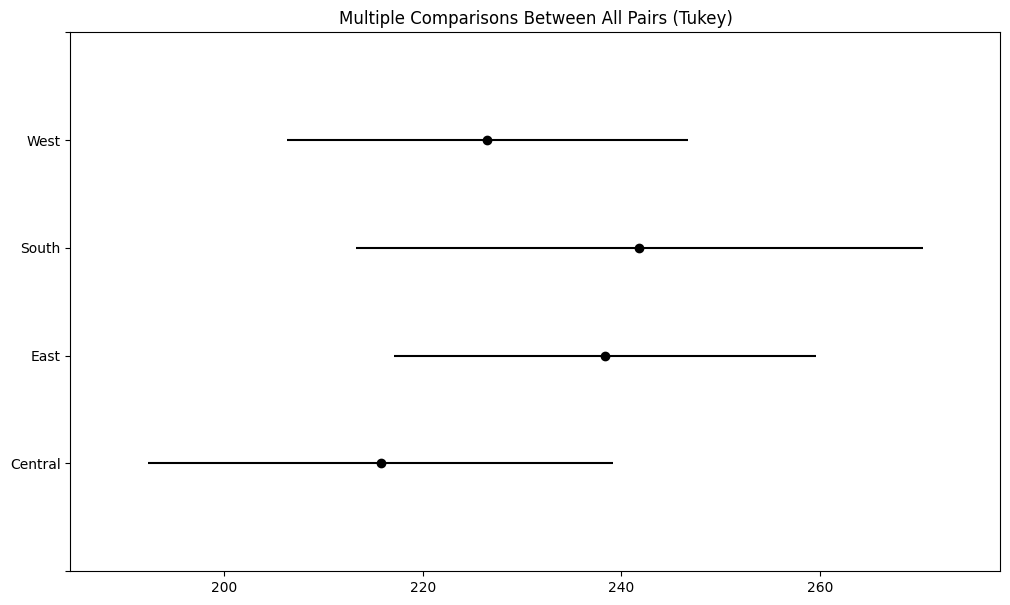

In [113]:
tukey = pairwise_tukeyhsd(df["Sales"], df["Region"])

# plotting group confidence intervals
tukey.plot_simultaneous(figsize = (12, 7))    
plt.vlines(x = 49.5, ymin = -0.3, ymax = 5, color = "#F0260A", linestyles = "dashed")
tukey.summary()

# x - indexes where to plot the lines.
# ymin, ymax - Respective beginning and end of each line. If scalars are provided, all lines will have same length.

# Category

In [114]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('Sales ~ Category', data=df).fit()
anova_results = anova_lm(model)
print(anova_results)


              df        sum_sq     mean_sq      F  PR(>F)
Category    2.00  195916227.41 97958113.70 265.51    0.00
Residual 9990.00 3685708121.42   368939.75    NaN     NaN


In [115]:
tukey_results = pairwise_tukeyhsd(df['Sales'], df['Category'])
print(tukey_results)


           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
     group1          group2      meandiff p-adj   lower     upper   reject
--------------------------------------------------------------------------
      Furniture Office Supplies -230.5108   0.0 -266.4575 -194.5641   True
      Furniture      Technology  102.9766   0.0   57.6567  148.2966   True
Office Supplies      Technology  333.4874   0.0  295.6121  371.3628   True
--------------------------------------------------------------------------


group1,group2,meandiff,p-adj,lower,upper,reject
Furniture,Office Supplies,-230.5108,0.0,-266.4575,-194.5641,True
Furniture,Technology,102.9766,0.0,57.6567,148.2966,True
Office Supplies,Technology,333.4874,0.0,295.6121,371.3628,True


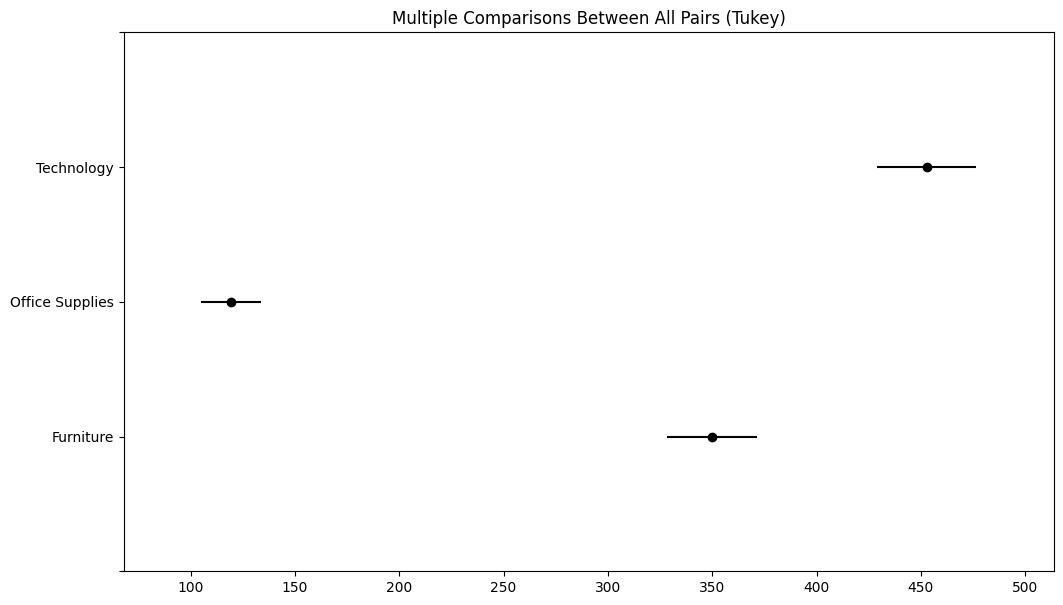

In [116]:
tukey = pairwise_tukeyhsd(df["Sales"], df["Category"])

# plotting group confidence intervals
tukey.plot_simultaneous(figsize = (12, 7))    
plt.vlines(x = 49.5, ymin = -0.3, ymax = 5, color = "#F0260A", linestyles = "dashed")
tukey.summary()

# x - indexes where to plot the lines.
# ymin, ymax - Respective beginning and end of each line. If scalars are provided, all lines will have same length.

# Sub-Category

In [121]:
df.rename(columns={"Sub-Category": "SubCategory"}, inplace=True)

In [122]:
df

,Order ID,Order Date,Ship Mode,Region,Product ID,Category,SubCategory,Product Name,Sales,Quantity,...,Normalized Sales,Standardized Profit,Standardized Sales,Winsorized Sales,Winsorized Profit,Scaled Sales,Scaled Profit,Log Sales,Log Profit,Category-SubCategory
0,PL-2015-110870,2015-12-12,First Class,West,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,299.94,6,...,0.11,NaN,0.11,299.94,NaN,1.27,NaN,2.48,NaN,Technology-Accessories
1,PL-2015-110870,2015-12-12,First Class,West,OFF-SU-10001225,Office Supplies,Supplies,Staple remover,25.76,7,...,-0.33,NaN,-0.33,25.76,NaN,-0.15,NaN,1.41,NaN,Office Supplies-Supplies
2,PL-2014-143210,2014-12-01,First Class,East,TEC-PH-10004434,Technology,Phones,Cisco IP Phone 7961G VoIP phone - Dark gray,271.90,2,...,0.07,NaN,0.07,271.90,NaN,1.13,NaN,2.43,NaN,Technology-Phones
3,PL-2014-143210,2014-12-01,First Class,East,FUR-FU-10003878,Furniture,Furnishings,"Linden 10"" Round Wall Clock, Black",45.84,3,...,-0.30,NaN,-0.30,45.84,NaN,-0.04,NaN,1.66,NaN,Furniture-Furnishings
4,PL-2014-143210,2014-12-01,First Class,East,FUR-FU-10002268,Furniture,Furnishings,Ultra Door Push Plate,9.82,2,...,-0.35,NaN,-0.35,9.82,NaN,-0.23,NaN,0.99,NaN,Furniture-Furnishings
5,PL-2016-139808,2016-10-07,Standard Class,West,OFF-FA-10001883,Office Supplies,Fasteners,"Alliance Super-Size Bands, Assorted Sizes",93.36,12,...,-0.22,NaN,-0.22,93.36,NaN,0.20,NaN,1.97,NaN,Office Supplies-Fasteners
6,PL-2015-110863,2015-11-17,Standard Class,Central,OFF-ST-10002756,Office Supplies,Storage,"Tennsco Stur-D-Stor Boltless Shelving, 5 Shelves, 24"" Deep, Sand",541.24,4,...,0.50,NaN,0.50,541.24,NaN,2.53,NaN,2.73,NaN,Office Supplies-Storage
7,PL-2015-110863,2015-11-17,Standard Class,Central,OFF-PA-10000474,Office Supplies,Paper,Easy-staple paper,106.32,3,...,-0.20,NaN,-0.20,106.32,NaN,0.27,NaN,2.03,NaN,Office Supplies-Paper
8,PL-2015-110863,2015-11-17,Standard Class,Central,FUR-CH-10002073,Furniture,Chairs,Hon Olson Stacker Chairs,1323.90,5,...,1.76,NaN,1.76,957.58,NaN,6.59,NaN,3.12,NaN,Furniture-Chairs
9,PL-2014-127859,2014-03-17,Second Class,East,OFF-PA-10003641,Office Supplies,Paper,Xerox 1909,126.62,6,...,-0.17,NaN,-0.17,126.62,NaN,0.37,NaN,2.10,NaN,Office Supplies-Paper


In [123]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

model = ols('Sales ~ SubCategory', data=df).fit()
anova_results = anova_lm(model)
print(anova_results)


                 df        sum_sq     mean_sq      F  PR(>F)
SubCategory   16.00  776264321.19 48516520.07 155.86    0.00
Residual    9976.00 3105360027.64   311283.08    NaN     NaN


In [124]:
tukey_results = pairwise_tukeyhsd(df['Sales'], df['SubCategory'])
print(tukey_results)


         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
   group1      group2    meandiff  p-adj    lower      upper    reject
----------------------------------------------------------------------
Accessories  Appliances    14.7811    1.0   -98.3578     127.92  False
Accessories         Art  -181.9058    0.0  -279.3039   -84.5076   True
Accessories     Binders    -82.414 0.0708  -167.5757     2.7476  False
Accessories   Bookcases    287.885    0.0   142.4724   433.2977   True
Accessories      Chairs   316.3578    0.0   212.2229   420.4927   True
Accessories     Copiers   1982.967    0.0   1738.861   2227.073   True
Accessories   Envelopes  -151.1069 0.0188  -290.6505   -11.5633   True
Accessories   Fasteners  -202.0378 0.0003  -350.2709   -53.8047   True
Accessories Furnishings  -120.1489  0.001  -213.4179     -26.88   True
Accessories      Labels  -181.6715    0.0   -304.311   -59.0321   True
Accessories    Machines  1429.5787    0.0  1236.7085   1622.449   True
Access

group1,group2,meandiff,p-adj,lower,upper,reject
Accessories,Appliances,14.7811,1.0,-98.3578,127.92,False
Accessories,Art,-181.9058,0.0,-279.3039,-84.5076,True
Accessories,Binders,-82.414,0.0708,-167.5757,2.7476,False
Accessories,Bookcases,287.885,0.0,142.4724,433.2977,True
Accessories,Chairs,316.3578,0.0,212.2229,420.4927,True
Accessories,Copiers,1982.967,0.0,1738.861,2227.073,True
Accessories,Envelopes,-151.1069,0.0188,-290.6505,-11.5633,True
Accessories,Fasteners,-202.0378,0.0003,-350.2709,-53.8047,True
Accessories,Furnishings,-120.1489,0.001,-213.4179,-26.88,True
Accessories,Labels,-181.6715,0.0,-304.311,-59.0321,True


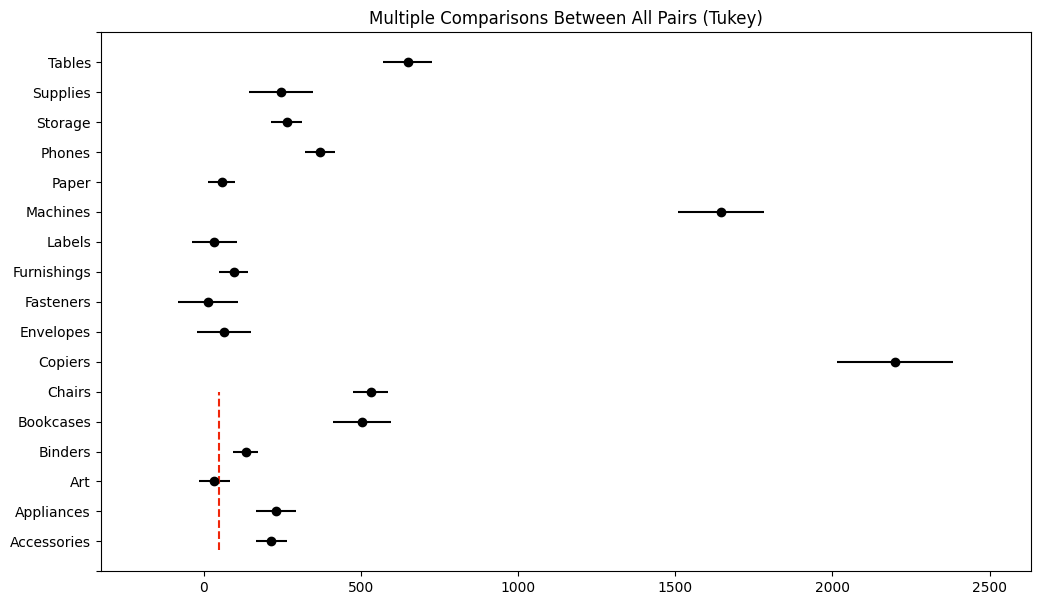

In [125]:
tukey = pairwise_tukeyhsd(df["Sales"], df["SubCategory"])

# plotting group confidence intervals
tukey.plot_simultaneous(figsize = (12, 7))    
plt.vlines(x = 49.5, ymin = -0.3, ymax = 5, color = "#F0260A", linestyles = "dashed")
tukey.summary()

# x - indexes where to plot the lines.
# ymin, ymax - Respective beginning and end of each line. If scalars are provided, all lines will have same length.